# Example of events generation

In [1]:
import sys
sys.path.append('../')

In [2]:
import jax
import jax.numpy as np
import jax.random as rjax
import scipy
rng = rjax.PRNGKey(seed=10)

/home/vitaly/miniconda3/envs/tf2/lib/python3.8/site-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [3]:
from helixgen.phspdecay import generate
import helixgen.resolution as res

In [4]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('xtick', labelsize=16)
matplotlib.rc('ytick', labelsize=16)
matplotlib.rc('font', size=18)

## Generate data as a python data structure
<!-- Generate 10000 events of the $D^+ \to [K^{*0} \to K^-\pi^+]\pi^+$ decay -->
Generate $D^0 \to [K_S^0 \to \pi^+ \pi^-] \pi^+ \pi^-$ decay events

Set cartesian covariance to determine detector resolution

In [5]:
smearer = lambda rng, gp: res.apply_resolution(
    rng, gp,
    res.apply_resolution_neutral_cartesian,
    res.apply_resolution_charged_cartesian)

In [6]:
%%time
w, events = generate(rng, '', 5000, smearer)

CPU times: user 6.75 s, sys: 37 ms, total: 6.79 s
Wall time: 6.72 s


Weights distribution

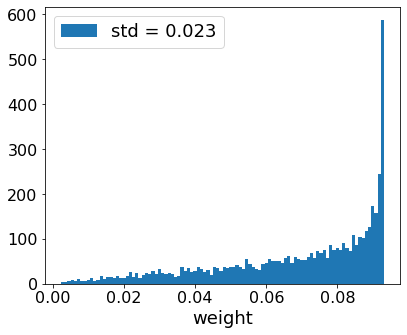

In [7]:
fig, ax = plt.subplots(figsize=(6,5))
ax.hist(w, bins=100, label=f'std = {w.std():.3f}');
ax.set_xlabel('weight')
ax.legend()
fig.tight_layout()

In [8]:
jax.tree_map(np.shape, events)

{'Ks0': {'mom': Momentum(px=(5000,), py=(5000,), pz=(5000,)),
  'pcl': (),
  'pos': Position(x=(5000,), y=(5000,), z=(5000,))},
 'pi+': {'hel': Helix(d0=(5000,), phi0=(5000,), omega=(5000,), z0=(5000,), tanl=(5000,)),
  'meas_hel': Helix(d0=(5000,), phi0=(5000,), omega=(5000,), z0=(5000,), tanl=(5000,)),
  'meas_mom': Momentum(px=(5000,), py=(5000,), pz=(5000,)),
  'meas_pos': Position(x=(5000,), y=(5000,), z=(5000,)),
  'mom': Momentum(px=(5000,), py=(5000,), pz=(5000,)),
  'momcov': (5000, 3, 3),
  'pcl': (),
  'pos': Position(x=(5000,), y=(5000,), z=(5000,)),
  'poscov': (5000, 3, 3)},
 'pi+_Ks0': {'hel': Helix(d0=(5000,), phi0=(5000,), omega=(5000,), z0=(5000,), tanl=(5000,)),
  'meas_hel': Helix(d0=(5000,), phi0=(5000,), omega=(5000,), z0=(5000,), tanl=(5000,)),
  'meas_mom': Momentum(px=(5000,), py=(5000,), pz=(5000,)),
  'meas_pos': Position(x=(5000,), y=(5000,), z=(5000,)),
  'mom': Momentum(px=(5000,), py=(5000,), pz=(5000,)),
  'momcov': (5000, 3, 3),
  'pcl': (),
  'pos': Po

In [9]:
nbins=100

In [10]:
def make_hist(ax, data, lbl, bins=nbins, rng=None):
    ax.hist(data, bins=bins, range=rng, histtype='step',
            label=f'std = {data.std():.3f}\nmean = {data.mean():.3f}');
    ax.set_xlabel(lbl)
    ax.legend()

In [11]:
def array_proj(ax, data, lbl, units=None, eqpref='', rng=None):
    xyz = 'xyz'
    for idx, a in enumerate(ax):
        if units:
            make_hist(a, data[idx], rf'${eqpref}{xyz[idx]}$ {lbl} ({units})', rng=rng)
        else:
            make_hist(a, data[idx], rf'${eqpref}{xyz[idx]}$ {lbl}', rng=rng)
        a.grid()
        a.minorticks_on()
        a.grid(which='minor', linestyle=':')

In [12]:
def position_proj(ax, data, lbl):
    return array_proj(ax, data, lbl, units='1 / MeV')

In [13]:
def momentum_proj(ax, data, lbl):
    return array_proj(ax, data, lbl, units='MeV', eqpref='p_')

Select a final-state particle to explore

In [14]:
pcllbl='pi-_Ks0'

## Spatial resolution
Generated position

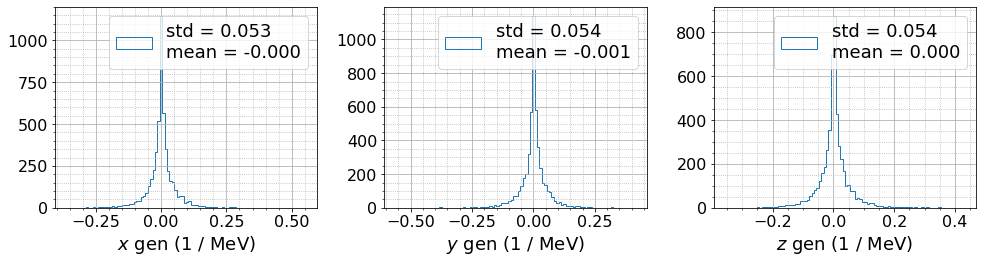

In [15]:
gen_pos = events[pcllbl]['pos']
fig, ax = plt.subplots(ncols=3, figsize=(14, 4))
position_proj(ax, gen_pos, 'gen')
fig.tight_layout()

Measured position

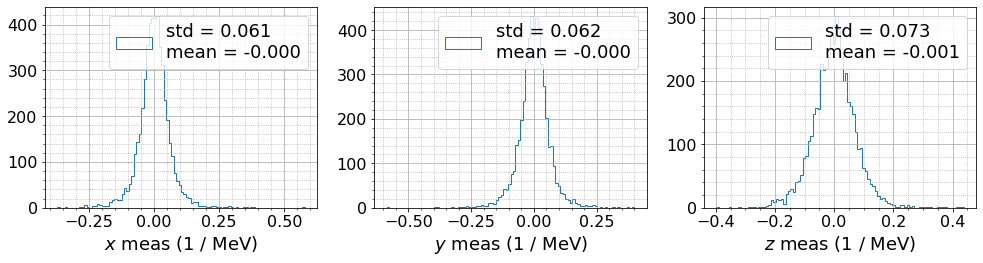

In [16]:
meas_pos = events[pcllbl]['meas_pos']
fig, ax = plt.subplots(ncols=3, figsize=(14, 4))
position_proj(ax, meas_pos, 'meas')
fig.tight_layout()

Offset and pull

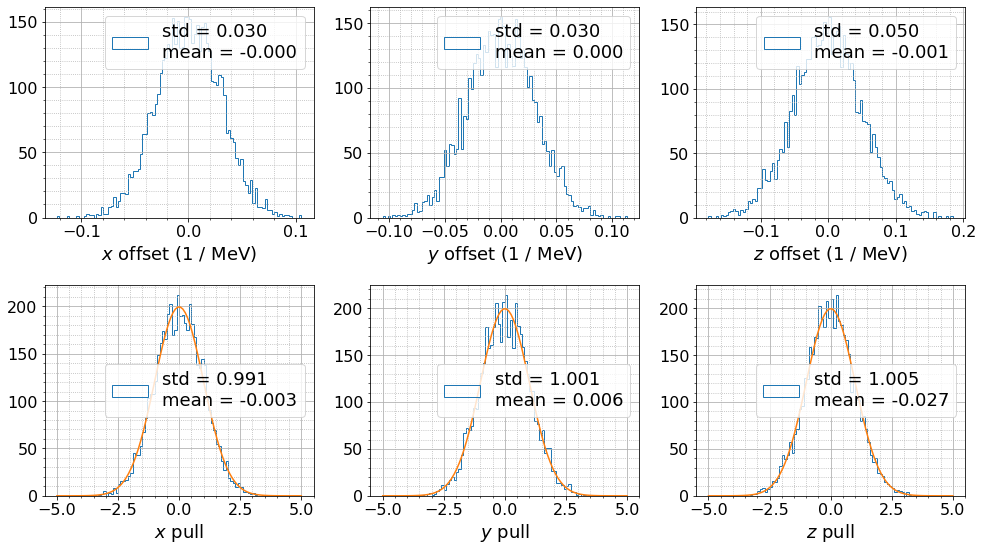

In [17]:
offset_pos = events[pcllbl]['meas_pos'] - events[pcllbl]['pos']
offset_pos = [offset_pos.as_array[:, i] for i in range(3)]
cov_pos = events[pcllbl]['poscov']
pull_pos = [offset_pos[i] / np.sqrt(cov_pos[:, i, i]) for i in range(3)]

fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(14, 8))
array_proj(ax[0], offset_pos, 'offset', '1 / MeV')
array_proj(ax[1], pull_pos, 'pull', rng=(-5, 5))

x = np.linspace(-5, 5, 100)
for a in ax[1]:
    a.plot(x, scipy.stats.norm.pdf(x) * pull_pos[0].size / 10)
fig.tight_layout()
plt.show()

## Momentum resolution
True momentum

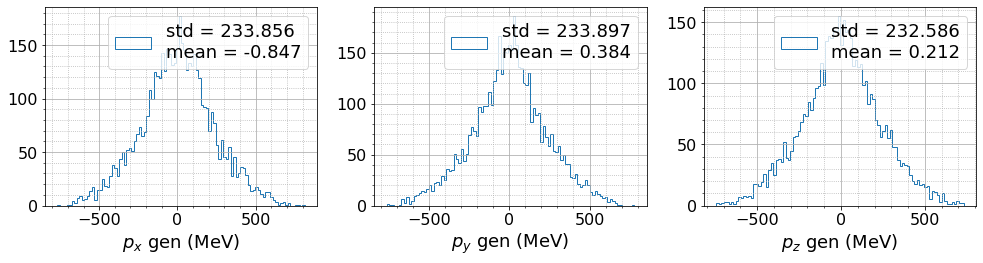

In [18]:
gen_mom = events[pcllbl]['mom']
fig, ax = plt.subplots(ncols=3, figsize=(14, 4))
momentum_proj(ax, gen_mom, 'gen')
fig.tight_layout()

Measured momentum

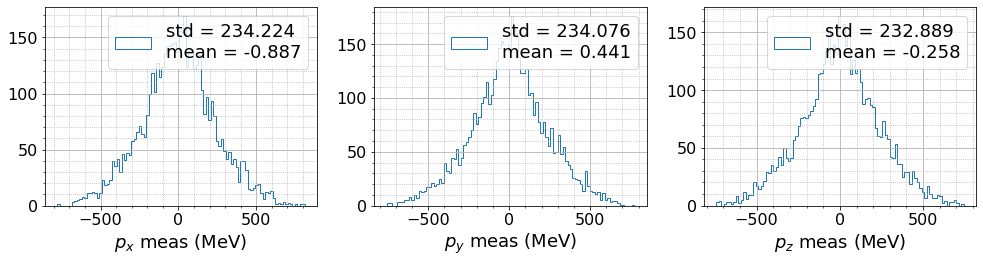

In [19]:
meas_mom = events[pcllbl]['meas_mom']
fig, ax = plt.subplots(ncols=3, figsize=(14, 4))
momentum_proj(ax, meas_mom, 'meas')
fig.tight_layout()

Offset and pull

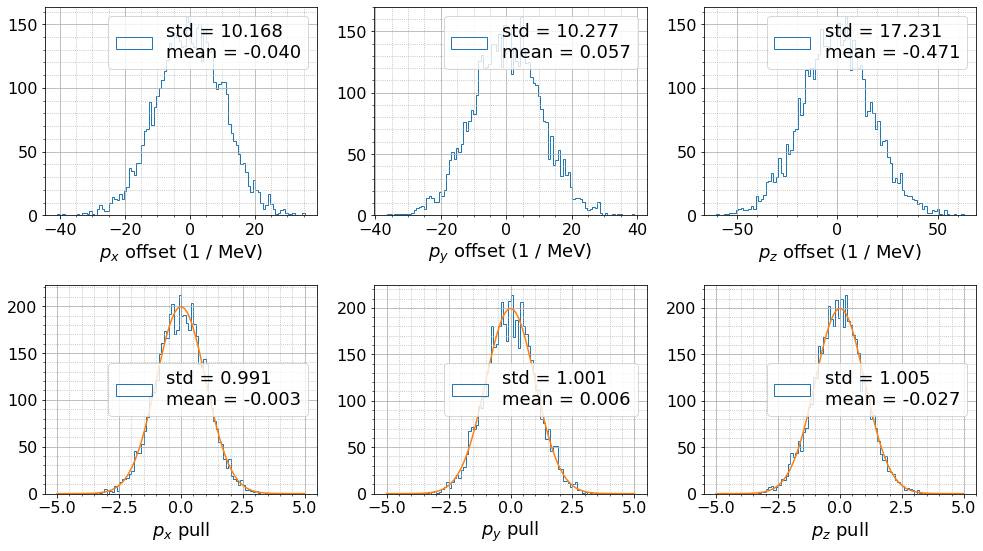

In [20]:
offset_mom = events[pcllbl]['meas_mom'].as_array - events[pcllbl]['mom'].as_array
offset_mom = [offset_mom[:, i] for i in range(3)]
cov_mom = events[pcllbl]['momcov']
pull_mom = [offset_mom[i] / np.sqrt(cov_mom[:, i, i]) for i in range(3)]

fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(14, 8))
array_proj(ax[0], offset_mom, 'offset', '1 / MeV', 'p_')
array_proj(ax[1], pull_mom, 'pull', None, 'p_', rng=(-5, 5))

x = np.linspace(-5, 5, 100)
for a in ax[1]:
    a.plot(x, scipy.stats.norm.pdf(x) * pull_mom[0].size / 10)

fig.tight_layout()
plt.show()

## Helix parameters

Distribution of the helix parameters

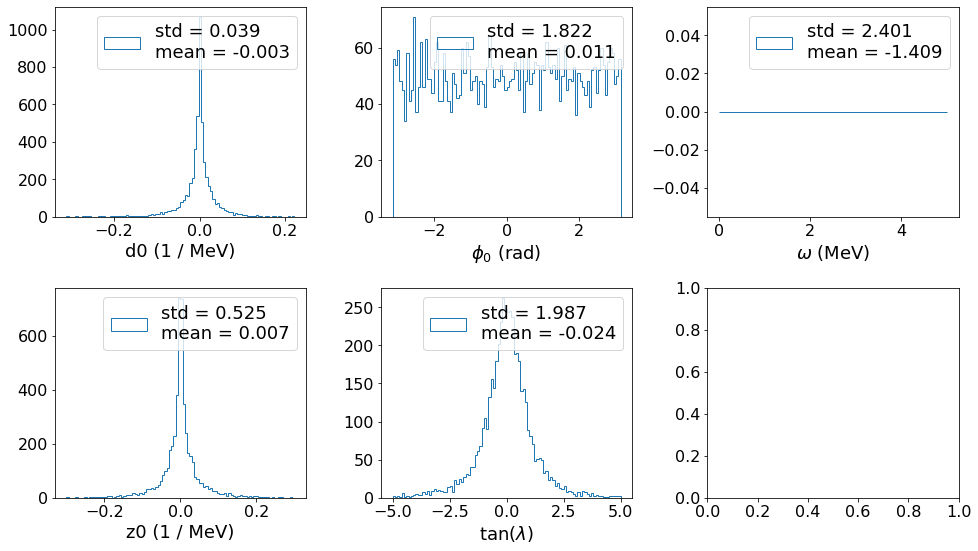

In [21]:
helix = events[pcllbl]['hel']

fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(14, 8))
make_hist(ax[0,0], helix.d0, 'd0 (1 / MeV)')
make_hist(ax[0,1], helix.phi0, r'$\phi_{0}$ (rad)')
make_hist(ax[0,2], helix.omega, r'$\omega$ (MeV)', rng=[0, 5])
make_hist(ax[1,0], helix.z0, 'z0 (1 / MeV)', rng=[-0.3, 0.3])
make_hist(ax[1,1], helix.tanl, 'tan($\lambda$)', rng=[-5, 5])
fig.tight_layout()

In [22]:
np.allclose(events['pi-']['pos'].as_array, events['pi-_Ks0']['pos'].as_array)

DeviceArray(False, dtype=bool)